# Analysis for EWG

In [32]:
import anduryl
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy import special
import math
from scipy import stats

import matplotlib.pyplot as plt
# plt.style.use('default')
%matplotlib inline

### Load project

In [33]:
# Create project and load Excalibur files
file = 'Dieren'
project = anduryl.Project()
# project.io.load_json(f'./{file}.json')
project.io.load_excalibur(f'./{file}.dtt', f'./{file}.rls')
project

Main project class.
Properties:
 - assessments
 - experts
 - io
 - items
 - main_results
 - results
Methods:
 - add_results_from_settings
 - calculate_decision_maker
 - calculate_expert_robustness
 - calculate_item_robustness
 - initialize
 - to_results

In [34]:
# setting up colors
import random

random.seed(5)
expert_colors = {}
used_colors = set()
for expert in range(7):
    available_colors = [c for c in plt.cm.tab20c.colors if c not in used_colors]
    if available_colors:
        color = random.choice(available_colors)
        used_colors.add(color)
        expert_colors[expert] = color

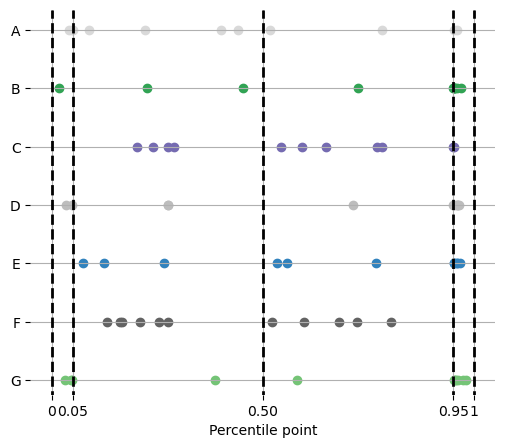

In [35]:
# Plot of realizations in the experts' distributions
from scipy.interpolate import interp1d

def eval_ecdf(obs, x):
    interp_ecdf = interp1d(obs[0], obs[1])
    return interp_ecdf(x)

# p vector
p = [0, 0.05, 0.5, 0.95, 1]

# realizations
realizations = pd.DataFrame.from_dict(project.items.as_dict())

# bounds
bounds = project.assessments.get_bounds(overshoot=0.1)

# select the question for which we want to plot the different CDFs
itemnr = np.linspace(1, 12, 12)

fig, ax = plt.subplots(figsize=(6, 5))

# Get experts assessments for the item
for i in itemnr: #for each item
    i = int(i)

    #extract assessments for item i, each row an expert
    itemassessment = project.assessments.get_array(experts='actual')[:, :, i]

    # Get bounds for the item i
    lower, upper = bounds[0][i], bounds[1][i]

    for j in range(7): #for each expert
        vals = [lower, itemassessment[j][0], itemassessment[j][1], itemassessment[j][2], upper]
        ax.scatter(eval_ecdf(np.array([vals, p]), realizations['realization'][i]), 6-j, 
                   color = expert_colors[j])

ax.set_xlabel('Percentile point')
ax.set_yticks([0, 1, 2, 3, 4, 5, 6])
ax.set_yticklabels(['G', 'F', 'E', 'D', 'C', 'B', 'A'])
ax.set_xticks([0, 0.05, 0.50, 0.95, 1])
ax.set_xticklabels(['0', '0.05', '0.50', '0.95', '1'])
ax.plot([0, 0], [-0.35, 6.35], '--k', linewidth = 2)
ax.plot([0.05, 0.05], [-0.35, 6.35], '--k', linewidth = 2)
ax.plot([0.5, 0.5], [-0.35, 6.35], '--k', linewidth = 2)
ax.plot([0.95, 0.95], [-0.35, 6.35], '--k', linewidth = 2)
ax.plot([1, 1], [-0.35, 6.35], '--k', linewidth = 2)
ax.set_xlim(-0.05,1.05)
ax.set_ylim(-0.25,6.35)
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

### Compute scores per expert and decision makers

In [36]:
# Calculate decision maker with performance based weights
project.calculate_expert_robustness(
    weight_type='global',
    overshoot=0.1,  # this is the k factor that adjusts the range of the support
    max_exclude = 0 # this means no robustness analysis is performed  
)

We have not defined user weights: that column should remain as NaNs.

In [37]:
pd.DataFrame.from_dict(project.experts.as_dict())

,Name,Info. score total,Info. score real.,Calibration score,Answered seed items,Weight,User weight
A,A,1.929668,2.212611,3.599451e-02,12.0,7.964185e-02,NaN
B,B,2.593257,3.286677,1.149098e-07,12.0,3.776715e-07,NaN
C,C,1.462674,1.454842,2.982314e-01,12.0,4.338794e-01,NaN
D,D,2.340738,3.118967,5.589438e-07,12.0,1.743328e-06,NaN
E,E,1.645497,2.040376,1.596044e-03,12.0,3.256530e-03,NaN
F,F,1.112197,0.889327,4.701352e-01,12.0,4.181039e-01,NaN
G,G,1.827387,2.407726,1.419482e-06,12.0,3.417724e-06,NaN


In [38]:
# Calculate decision maker with global weights, using performance based
project.calculate_decision_maker(
    weight_type='global',
    overshoot=0.1,
    exp_id='DMgl_noopt',
    calpower=1.0, # Calibration power, relative weight of the calibration compared
                  # to the information score
    exp_name='Decision Maker global weights no opt',
    alpha=0,    # Significance level for the calibration score. Experts with a lower
                  # calibration score get zero weight. If None, the weights
                  # are returnes for all possible significance levels 
                  # (unique calibration scores)
    overwrite=True
)

project.experts.user_weights[0:7] = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] # Equal weight DM

# Calculate decision maker with user defined weights
project.calculate_decision_maker(
    weight_type='user',
    overshoot=0.1,
    exp_id='DMeq',
    calpower=1.0,
    exp_name='Decision Maker equal weights',
    alpha=0.05,
    overwrite=True
)

In [39]:
# Calculate decision maker with global weights, using performance based
project.calculate_decision_maker(
    weight_type='global',
    overshoot=0.1,
    exp_id='DMgl',
    calpower=1.0, # Calibration power, relative weight of the calibration compared
                  # to the information score
    exp_name='Decision Maker global weights',
    alpha=0.05,    # Significance level for the calibration score. Experts with a lower
                  # calibration score get zero weight. If None, the weights
                  # are returnes for all possible significance levels 
                  # (unique calibration scores)
    overwrite=True
)

In [40]:
pd.DataFrame.from_dict(project.experts.as_dict())

,Name,Info. score total,Info. score real.,Calibration score,Answered seed items,Weight,User weight
A,A,1.929668,2.212611,3.599451e-02,12.0,0.000000,1.0
B,B,2.593257,3.286677,1.149098e-07,12.0,0.000000,1.0
C,C,1.462674,1.454842,2.982314e-01,12.0,0.433879,1.0
D,D,2.340738,3.118967,5.589438e-07,12.0,0.000000,1.0
E,E,1.645497,2.040376,1.596044e-03,12.0,0.000000,1.0
F,F,1.112197,0.889327,4.701352e-01,12.0,0.418104,1.0
G,G,1.827387,2.407726,1.419482e-06,12.0,0.000000,1.0
DMgl_noopt,Decision Maker global weights no opt,0.774102,0.658902,4.701352e-01,NaN,0.309773,NaN
DMeq,Decision Maker equal weights,0.482184,0.567152,1.289207e-01,NaN,0.073118,NaN
DMgl,Decision Maker global weights,0.863641,0.651589,4.701352e-01,NaN,0.306335,NaN


### Robustness analysis

A way of checking the robustness of the project is by removing one or multiple items or experts from the project in turn, and checking the resulting information and calibration scores. If these values will change a lot, it shows that the number of items or experts might be a bit too low.

In [41]:
# Exclude up to four items
project.calculate_item_robustness(
    weight_type='global',
    overshoot=0.1,
    max_exclude=4,
    min_exclude=0,
    calpower=1.0,
    alpha=0.05
)

In the next table, you can see the score changes when different questions are extracted of the calculations. As this is an artifitial example, the Calibration Score has a extrange behaviour, where there is no change of the score or only one single change when one or multiple questions are removed. You are now encouraged to take some of the examples on the github repository that you will find at the end of this notebook and try some of the different examples you can find there.

In [42]:
robres = project.main_results.item_robustness
index = [val[:] if val else 'None' for val in list(robres.keys())]
pd.DataFrame(data=robres.values(), index=index, columns=['Info score total' ,'Info score realizations', 'Calibration score'])

,Info score total,Info score realizations,Calibration score
None,0.863641,0.651589,0.470135
"(item00,)",0.899697,0.694566,0.491968
"(item01,)",0.764282,0.651082,0.369574
"(item02,)",0.676579,0.520349,0.491968
"(item03,)",0.785330,0.694578,0.491968
...,...,...,...
"(item07, item08, item09, item10)",0.994689,0.791408,0.640102
"(item07, item08, item09, item11)",0.956361,0.730117,0.640102
"(item07, item08, item10, item11)",0.976203,0.768400,0.533701
"(item07, item09, item10, item11)",0.776191,0.709398,0.533701


When more questions are extracted, the variation of the Information Score grows. This means that the calculations results are more sensitive when more questions are extracted.

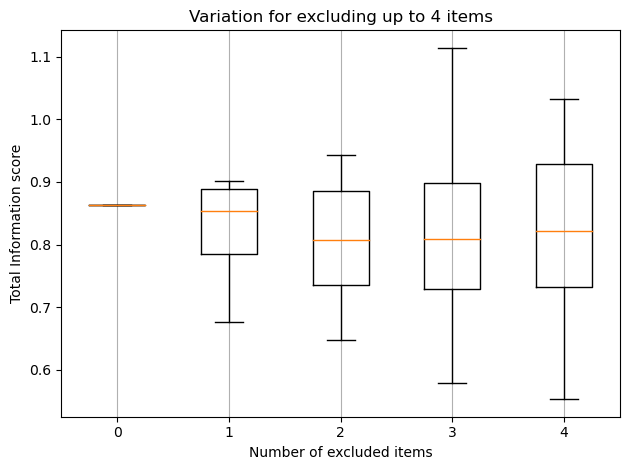

In [43]:
# Collect the results per number of excluded items
robres = project.main_results.item_robustness
values = {}
for key, value in robres.items():
    # Add dictionary item if it does not exist yet
    if len(key) not in values.keys():
        values[len(key)] = []
    # Append total information score (the 1st value)
    values[len(key)].append(value[0])
        
# Show the variation in calibration and information scores.
fig, ax = plt.subplots()
ax.boxplot(values.values(), positions=list(values.keys()));
ax.set_xlabel('Number of excluded items')
ax.set_ylabel('Total Information score')
ax.set_title('Variation for excluding up to 4 items');
ax.grid(axis='x')
fig.tight_layout()

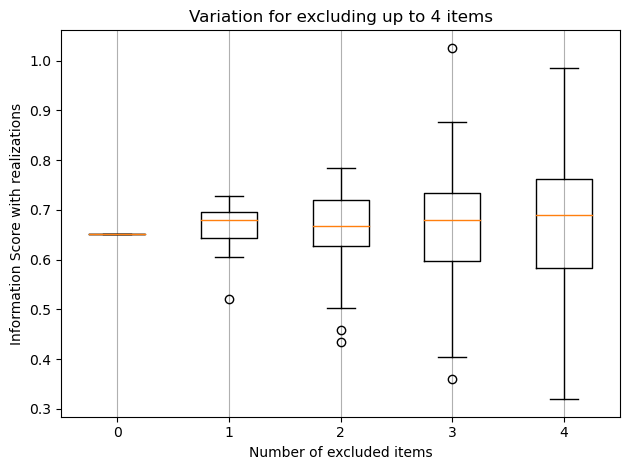

In [44]:
# Collect the results per number of excluded items
robres = project.main_results.item_robustness
values = {}
for key, value in robres.items():
    # Add dictionary item if it does not exist yet
    if len(key) not in values.keys():
        values[len(key)] = []
    # Append information score with realizations
    values[len(key)].append(value[1])
        
# Show the variation in calibration and information scores.
fig, ax = plt.subplots()
ax.boxplot(values.values(), positions=list(values.keys()));
ax.set_xlabel('Number of excluded items')
ax.set_ylabel('Information Score with realizations')
ax.set_title('Variation for excluding up to 4 items');
ax.grid(axis='x')
fig.tight_layout()

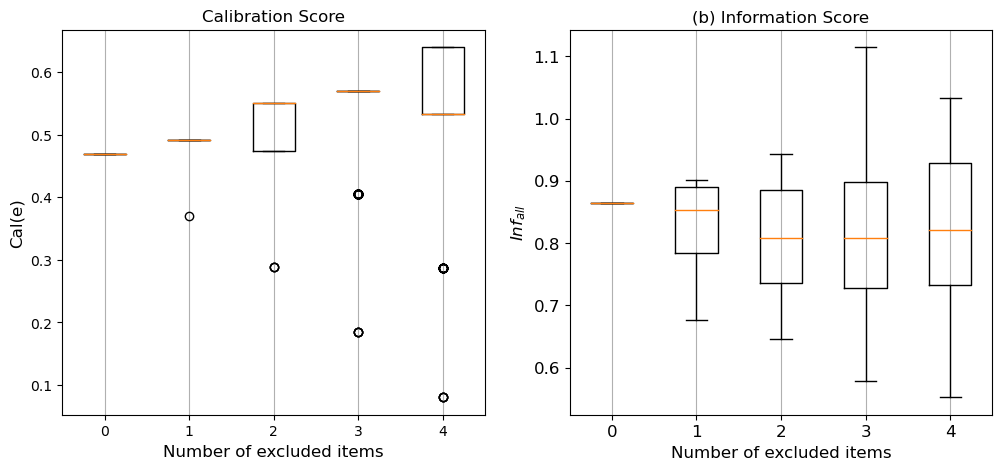

In [45]:
# Collect the results per number of excluded items: calibration
robres = project.main_results.item_robustness
values = {}
for key, value in robres.items():
    # Add dictionary item if it does not exist yet
    if len(key) not in values.keys():
        values[len(key)] = []
    # Append calibration score (the 3th value, index 2 since Python is zero-based)
    values[len(key)].append(value[2])

# Collect the results per number of excluded items: information
values_inf = {}
for key, value in robres.items():
    # Add dictionary item if it does not exist yet
    if len(key) not in values_inf.keys():
        values_inf[len(key)] = []
    # Append total information score (the 1st value)
    values_inf[len(key)].append(value[0])
        
# Show the variation in calibration and information scores.
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].boxplot(values.values(), positions=list(values.keys()));
ax[0].set_xlabel('Number of excluded items', fontsize=12)
ax[0].set_ylabel('Cal(e)', fontsize=12)
ax[0].set_title('Calibration Score', fontsize=12);
ax[0].grid(axis='x')
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='minor', labelsize=12)

ax[1].boxplot(values_inf.values(), positions=list(values.keys()));
ax[1].set_xlabel('Number of excluded items', fontsize=12)
ax[1].set_ylabel('${Inf_{all}}$', fontsize=12)
ax[1].set_title('(b) Information Score', fontsize=12);
ax[1].grid(axis='x')
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='minor', labelsize=12)

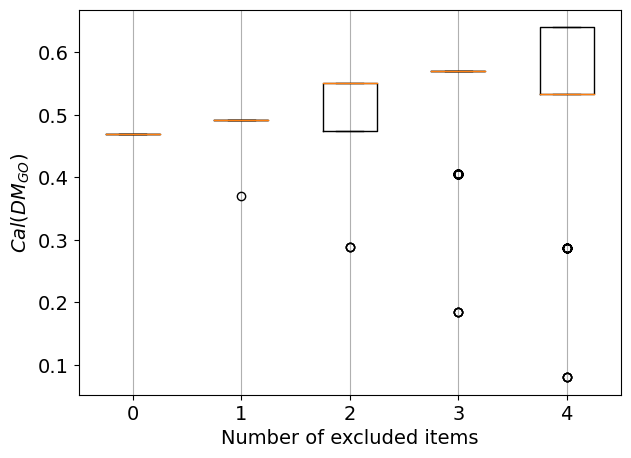

In [46]:
# Collect the results per number of excluded items: calibration
robres = project.main_results.item_robustness
values = {}
for key, value in robres.items():
    # Add dictionary item if it does not exist yet
    if len(key) not in values.keys():
        values[len(key)] = []
    # Append calibration score (the 3th value, index 2 since Python is zero-based)
    values[len(key)].append(value[2])

        
# Show the variation in calibration and information scores.
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.boxplot(values.values(), positions=list(values.keys()));
ax.set_xlabel('Number of excluded items', fontsize=14)
ax.set_ylabel('${Cal(DM_{GO})}$', fontsize=14)
# ax.set_title('Calibration Score', fontsize=12);
ax.grid(axis='x')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)


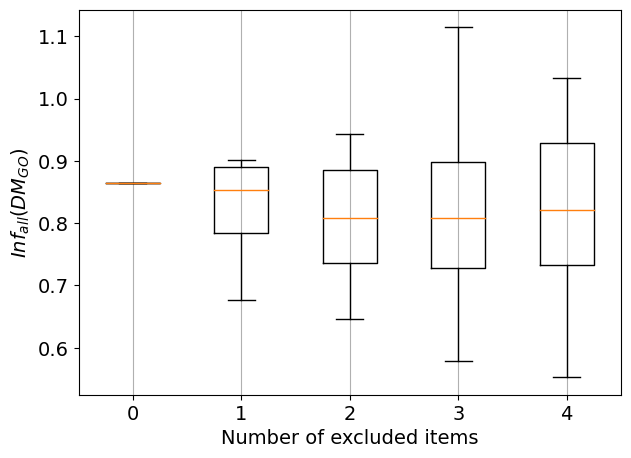

In [47]:
# Collect the results per number of excluded items: calibration
robres = project.main_results.item_robustness

# Collect the results per number of excluded items: information
values_inf = {}
for key, value in robres.items():
    # Add dictionary item if it does not exist yet
    if len(key) not in values_inf.keys():
        values_inf[len(key)] = []
    # Append total information score (the 1st value)
    values_inf[len(key)].append(value[0])
        
# Show the variation in calibration and information scores.
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.boxplot(values_inf.values(), positions=list(values.keys()));
ax.set_xlabel('Number of excluded items', fontsize=14)
ax.set_ylabel('${Inf_{all}(DM_{GO})}$', fontsize=14)
# ax.set_title('(b) Information Score', fontsize=12);
ax.grid(axis='x')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

### Obtained CDF for overtopping erosion

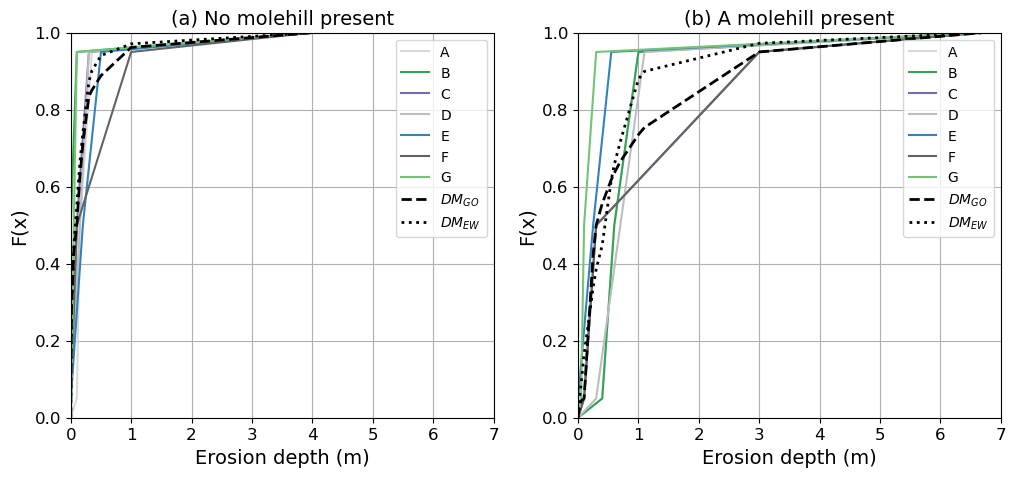

In [48]:
#select the question for which we want to plot the different CDFs
item = 'item12'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr]

# Plot experts' cdfs
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for i, assessment in enumerate(itemassessment):
    ax[0].plot(np.r_[np.exp(lower), assessment, np.exp(upper)], np.r_[0.0, project.assessments.quantiles, 1.0], color = expert_colors[i],
            label='{}'.format(project.experts.ids[i]))
    
# Plot DM's cdf
ax[0].plot(*project.assessments.full_cdf['DMgl'][itemnr].T, label='${DM_{GO}}$', ms=4, color='k', ls='--', lw=2)
ax[0].plot(*project.assessments.full_cdf['DMeq'][itemnr].T, label='${DM_{EW}}$', ms=4, color='k', ls=':', lw=2)

ax[0].legend()

ax[0].set_title('(a) No molehill present', fontsize=14)
ax[0].set_xlabel('Erosion depth (m)', fontsize=14)
ax[0].set_ylabel('F(x)', fontsize=14)
ax[0].grid()
ax[0].set_ylim(0,1)
ax[0].set_xlim(0,7)

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].tick_params(axis='both', which='minor', labelsize=12)

#select the question for which we want to plot the different CDFs
item = 'item13'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr] #added min 0


for i, assessment in enumerate(itemassessment):
    ax[1].plot(np.r_[np.exp(lower), assessment, np.exp(upper)], np.r_[0.0, project.assessments.quantiles, 1.0], color = expert_colors[i],
            label='{}'.format(project.experts.ids[i]))
    
# Plot DM's cdf
ax[1].plot(*project.assessments.full_cdf['DMgl'][itemnr].T, label='${DM_{GO}}$', ms=4, color='k', ls='--', lw=2)
ax[1].plot(*project.assessments.full_cdf['DMeq'][itemnr].T, label='${DM_{EW}}$', ms=4, color='k', ls=':', lw=2)

ax[1].legend()

ax[1].set_title('(b) A molehill present', fontsize=14)
ax[1].set_xlabel('Erosion depth (m)', fontsize=14)
ax[1].set_ylabel('F(x)', fontsize=14)
ax[1].grid()
ax[1].set_ylim(0,1)
ax[1].set_xlim(0,7)

ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='minor', labelsize=12)


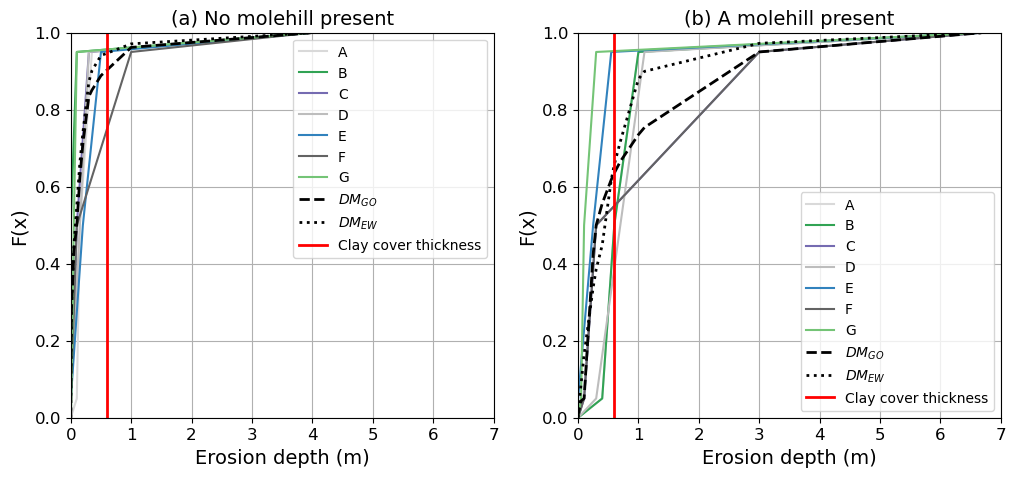

In [278]:
#select the question for which we want to plot the different CDFs
item = 'item12'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr]

# Plot experts' cdfs
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for i, assessment in enumerate(itemassessment):
    ax[0].plot(np.r_[np.exp(lower), assessment, np.exp(upper)], np.r_[0.0, project.assessments.quantiles, 1.0], color = expert_colors[i],
            label='{}'.format(project.experts.ids[i]))
    
# Plot DM's cdf
ax[0].plot(*project.assessments.full_cdf['DMgl'][itemnr].T, label='${DM_{GO}}$', ms=4, color='k', ls='--', lw=2)
ax[0].plot(*project.assessments.full_cdf['DMeq'][itemnr].T, label='${DM_{EW}}$', ms=4, color='k', ls=':', lw=2)
ax[0].plot([0.6, 0.6],[0, 1], label='Clay cover thickness', ms=4, color='r', lw=2)

ax[0].legend()

ax[0].set_title('(a) No molehill present', fontsize=14)
ax[0].set_xlabel('Erosion depth (m)', fontsize=14)
ax[0].set_ylabel('F(x)', fontsize=14)
ax[0].grid()
ax[0].set_ylim(0,1)
ax[0].set_xlim(0,7)

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].tick_params(axis='both', which='minor', labelsize=12)

#select the question for which we want to plot the different CDFs
item = 'item13'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr] #added min 0


for i, assessment in enumerate(itemassessment):
    ax[1].plot(np.r_[np.exp(lower), assessment, np.exp(upper)], np.r_[0.0, project.assessments.quantiles, 1.0], color = expert_colors[i],
            label='{}'.format(project.experts.ids[i]))
    
# Plot DM's cdf
ax[1].plot(*project.assessments.full_cdf['DMgl'][itemnr].T, label='${DM_{GO}}$', ms=4, color='k', ls='--', lw=2)
ax[1].plot(*project.assessments.full_cdf['DMeq'][itemnr].T, label='${DM_{EW}}$', ms=4, color='k', ls=':', lw=2)
ax[1].plot([0.6, 0.6],[0, 1], label='Clay cover thickness', ms=4, color='r', lw=2)

ax[1].legend()

ax[1].set_title('(b) A molehill present', fontsize=14)
ax[1].set_xlabel('Erosion depth (m)', fontsize=14)
ax[1].set_ylabel('F(x)', fontsize=14)
ax[1].grid()
ax[1].set_ylim(0,1)
ax[1].set_xlim(0,7)

ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='minor', labelsize=12)

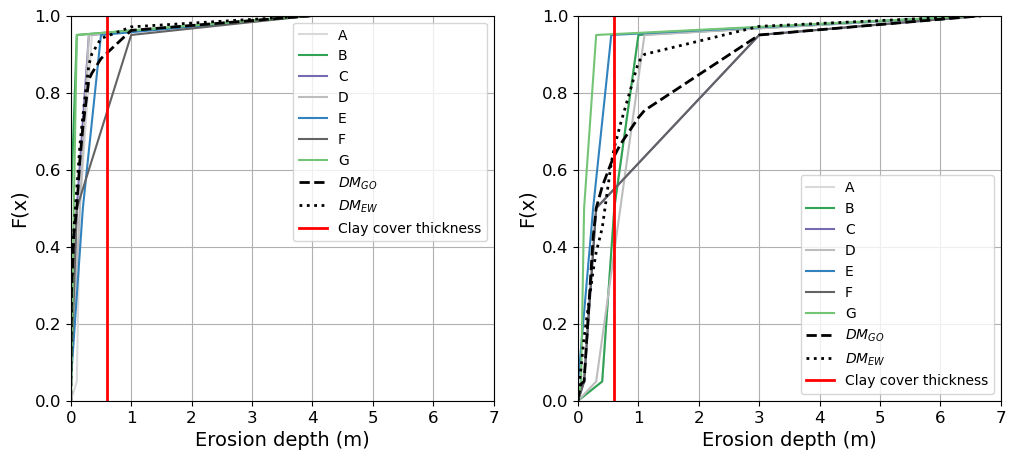

In [285]:
#select the question for which we want to plot the different CDFs
item = 'item12'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr]

# Plot experts' cdfs
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for i, assessment in enumerate(itemassessment):
    ax[0].plot(np.r_[np.exp(lower), assessment, np.exp(upper)], np.r_[0.0, project.assessments.quantiles, 1.0], color = expert_colors[i],
            label='{}'.format(project.experts.ids[i]))
    
# Plot DM's cdf
ax[0].plot(*project.assessments.full_cdf['DMgl'][itemnr].T, label='${DM_{GO}}$', ms=4, color='k', ls='--', lw=2)
ax[0].plot(*project.assessments.full_cdf['DMeq'][itemnr].T, label='${DM_{EW}}$', ms=4, color='k', ls=':', lw=2)
ax[0].plot([0.6, 0.6],[0, 1], label='Clay cover thickness', ms=4, color='r', lw=2)

ax[0].legend()

# ax[0].set_title('(a) No molehill present', fontsize=14)
ax[0].set_xlabel('Erosion depth (m)', fontsize=14)
ax[0].set_ylabel('F(x)', fontsize=14)
ax[0].grid()
ax[0].set_ylim(0,1)
ax[0].set_xlim(0,7)

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].tick_params(axis='both', which='minor', labelsize=12)

#select the question for which we want to plot the different CDFs
item = 'item13'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr] #added min 0


for i, assessment in enumerate(itemassessment):
    ax[1].plot(np.r_[np.exp(lower), assessment, np.exp(upper)], np.r_[0.0, project.assessments.quantiles, 1.0], color = expert_colors[i],
            label='{}'.format(project.experts.ids[i]))
    
# Plot DM's cdf
ax[1].plot(*project.assessments.full_cdf['DMgl'][itemnr].T, label='${DM_{GO}}$', ms=4, color='k', ls='--', lw=2)
ax[1].plot(*project.assessments.full_cdf['DMeq'][itemnr].T, label='${DM_{EW}}$', ms=4, color='k', ls=':', lw=2)
ax[1].plot([0.6, 0.6],[0, 1], label='Clay cover thickness', ms=4, color='r', lw=2)

ax[1].legend()

# ax[1].set_title('(b) A molehill present', fontsize=14)
ax[1].set_xlabel('Erosion depth (m)', fontsize=14)
ax[1].set_ylabel('F(x)', fontsize=14)
ax[1].grid()
ax[1].set_ylim(0,1)
ax[1].set_xlim(0,7)

ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='minor', labelsize=12)

In [282]:
# compute range of probabilities of failure: no molehills

item = 'item12'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr]

def expert_cdf(lower, upper, assessment, log_scale=False, quantiles = [0.05, 0.50, 0.95]):
    expert_cdf = np.zeros([len(assessment)+2, 2])
    if log_scale:
        expert_cdf[:,1] = np.r_[np.exp(lower), assessment, np.exp(upper)]
    else:
        expert_cdf[:,1] = np.r_[np.exp(lower), assessment, np.exp(upper)]
    expert_cdf[:,0] = np.r_[0.0, quantiles[0], quantiles[1], quantiles[2], 1.0]

    return expert_cdf

expert_A_12 = expert_cdf(lower, upper, itemassessment[0], log_scale= True)
expert_B_12 = expert_cdf(lower, upper, itemassessment[1], log_scale= True)
expert_C_12 = expert_cdf(lower, upper, itemassessment[2], log_scale= True)
expert_D_12 = expert_cdf(lower, upper, itemassessment[3], log_scale= True)
expert_E_12 = expert_cdf(lower, upper, itemassessment[4], log_scale= True)
expert_F_12 = expert_cdf(lower, upper, itemassessment[5], log_scale= True)
expert_G_12 = expert_cdf(lower, upper, itemassessment[6], log_scale= True)

def eval_cdf(obs, x):
    interp_ecdf = interp1d(obs[:,1], obs[:,0], kind='linear')
    return interp_ecdf(x)

def eval_inverse_cdf(obs, x):
    inverted_ecdf = interp1d(obs[:,0], obs[:,1], kind='linear')
    return inverted_ecdf(x)

print('No moles')
print(eval_cdf(expert_A_12, 0.6))
print(eval_cdf(expert_B_12, 0.6))
print(eval_cdf(expert_C_12, 0.6))
print(eval_cdf(expert_D_12, 0.6))
print(eval_cdf(expert_E_12, 0.6))
print(eval_cdf(expert_F_12, 0.6))
print(eval_cdf(expert_G_12, 0.6))

print(eval_inverse_cdf(project.assessments.full_cdf['DMgl'][itemnr], 0.6))
print(eval_inverse_cdf(project.assessments.full_cdf['DMeq'][itemnr], 0.6))

No moles
0.9534425098190558
0.956441519739083
0.9540749002464269
0.9540749002464269
0.9514363392721987
0.75
0.956441519739083
0.9032139048712355
0.9468176063795589


In [284]:
# compute range of probabilities of failure: molehills

item = 'item13'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr]

def expert_cdf(lower, upper, assessment, log_scale=False, quantiles = [0.05, 0.50, 0.95]):
    expert_cdf = np.zeros([len(assessment)+2, 2])
    if log_scale:
        expert_cdf[:,1] = np.r_[np.exp(lower), assessment, np.exp(upper)]
    else:
        expert_cdf[:,1] = np.r_[np.exp(lower), assessment, np.exp(upper)]
    expert_cdf[:,0] = np.r_[0.0, quantiles[0], quantiles[1], quantiles[2], 1.0]

    return expert_cdf

expert_A_13 = expert_cdf(lower, upper, itemassessment[0], log_scale= True)
expert_B_13 = expert_cdf(lower, upper, itemassessment[1], log_scale= True)
expert_C_13 = expert_cdf(lower, upper, itemassessment[2], log_scale= True)
expert_D_13 = expert_cdf(lower, upper, itemassessment[3], log_scale= True)
expert_E_13 = expert_cdf(lower, upper, itemassessment[4], log_scale= True)
expert_F_13 = expert_cdf(lower, upper, itemassessment[5], log_scale= True)
expert_G_13 = expert_cdf(lower, upper, itemassessment[6], log_scale= True)

def eval_cdf(obs, x):
    interp_ecdf = interp1d(obs[:,1], obs[:,0], kind='linear')
    return interp_ecdf(x)

def eval_inverse_cdf(obs, x):
    inverted_ecdf = interp1d(obs[:,0], obs[:,1], kind='linear')
    return inverted_ecdf(x)

print('With moles')
print(eval_cdf(expert_A_13, 0.6))
print(eval_cdf(expert_B_13, 0.6))
print(eval_cdf(expert_C_13, 0.6))
print(eval_cdf(expert_D_13, 0.6))
print(eval_cdf(expert_E_13, 0.6))
print(eval_cdf(expert_F_13, 0.6))
print(eval_cdf(expert_G_13, 0.6))

print(eval_inverse_cdf(project.assessments.full_cdf['DMgl'][itemnr], 0.6))
print(eval_inverse_cdf(project.assessments.full_cdf['DMeq'][itemnr], 0.6))

With moles
0.5
0.5
0.55
0.38750000000000007
0.9504077721020753
0.55
0.9523507745831253
0.6354634980487917
0.6574239992921254


### Method van Bergeijk et al.: 500 storms, uncertainty due to it

Boundary conditions

In [49]:
def steepness(Hs, Tm0):
    return Hs/((9.81*Tm0**2)/2/np.pi)

def iribarren(Hs, Tm0, angle_slope):
    return np.tan(angle_slope)/np.sqrt(steepness(Hs, Tm0))

def params_distr_vols(q, Hs, Tm0, Pov):
    Tm = 1.1*Tm0
    b = 0.73 + 55*(q/(9.81*Hs*Tm0))**(0.8)
    a = (1/special.gamma(1 + 1/b))*(q*Tm/Pov)
    return a, b

def pov(Rc, Ru):
    return np.exp(-((np.sqrt(-np.log(0.02)))*Rc/Ru)**2)

def Ru(Hs, Tm0, angle_slope):
    ru = 1.65*Hs*1*1*1*iribarren(Hs, Tm0, angle_slope)
    max_value = Hs*1*1*(4-1.5/iribarren(Hs, Tm0, angle_slope))
    return min(ru, max_value)

def mean_discharge(Hs, Tm0, Rc, angle_slope):
    estimation = 0.023*np.sqrt(9.81*Hs**3)*1*iribarren(Hs, Tm0, angle_slope)*np.exp(-(2.7*Rc/(Hs*iribarren(Hs, Tm0, angle_slope)))**1.3)
    max_value = 0.09*np.sqrt(9.81*Hs**3)*np.exp(-(1.5*Rc/Hs)**1.3)
    return min(estimation, max_value)

def weibull_cdf(V, a, b):
    return 1 - np.exp(-(V/a)**b)

def weibull_icdf(P, a, b):
    return a*(-np.log(1-P))**(1/b)

def individual_events(Hs, Tm0, Rc, angle_slope, Pov, n_samples, n_seed):
    q_mean = mean_discharge(Hs, Tm0, Rc, angle_slope)
    a, b = params_distr_vols(q_mean, Hs, Tm0, Pov)
    unif_samples = stats.uniform.rvs(0, 1, size = n_samples, random_state=n_seed)
    V_samples = weibull_icdf(unif_samples, a, b)
    vel_samples = 4.5*V_samples**0.3
    h_samples = 0.133*V_samples**0.5
    T_samples = 3.9*V_samples**0.46
    samples = np.vstack((V_samples, vel_samples, h_samples, T_samples)).T
    return samples

In [58]:
# Case study data
total_height = 9
crest_legth = 4
slope = 3
angle_slope = math.atan(1/3)
# print(angle_slope*180/np.pi)
slope_length = 9/math.sin(angle_slope)
# print(slope_length)

# Input variables
Hs = 2
Tm0 = 7
water_level = 5
Rc = total_height - water_level
t_storm = 6 #hours of storm

# number of iterations
simulations = 500

# print(iribarren(Hs, Tm0, angle_slope))

# Number of overtopping events
n_events = np.round((t_storm*3600/(1.1*Tm0))*pov(Rc, Ru(Hs, Tm0, angle_slope)))


# Generate overtopping events for each possible storm
n_samples = int(n_events)
seeds = np.arange(1, simulations+1)
samples = [individual_events(Hs, Tm0, Rc, angle_slope, pov(Rc, Ru(Hs, Tm0, angle_slope)), 
                            n_samples, seeds[i]) for i in range(len(seeds))]

# len(samples)


500

Flow characteristics along the crest and slope: 1D shallow water equations

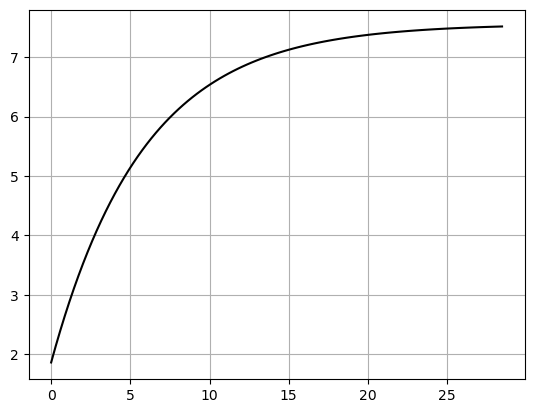

In [166]:
# def max_u_horizontal(x_coord, friction, inst_Q, u_0):
#     u_horizontal = (friction*x_coord/2/inst_Q+1/u_0)**(-1)
#     return u_horizontal

def max_u_horizontal(x_coord, friction, inst_Q, u_0):
    denom = friction*x_coord/(2*inst_Q) + 1/u_0
    u_horizontal = np.where(np.isfinite(denom) & (denom != 0),
                            1/denom,
                            np.nan)
    return u_horizontal

def max_u_slope(x_coord, u_0, friction, inst_Q, angle_slope):\
    # note tht x_coord is defined along the slope
    alpha = (9.81*np.sin(angle_slope))**(1/3)
    beta = np.sqrt(friction/2/inst_Q)
    mu = u_0 - alpha/beta
    u_slope = alpha/beta + mu*np.exp(-3*(beta**2)*alpha*x_coord/np.cos(angle_slope))
    return u_slope

# define parameters
friction = 0.01

# max velocity at the end of the crest for all the samples
u_end_crest= [max_u_horizontal(4, friction, samples[i][:,1]*samples[i][:,2], samples[i][:,1]) for i in range(len(samples))]

# max velocity at the slope for all the samples
coordinates_to_evaluate = np.linspace(0, slope_length, 100)
friction = np.array([friction]*len(coordinates_to_evaluate))
max_velocities = []

for i in range(simulations):
    max_velocities_2d = np.zeros((len(samples), len(coordinates_to_evaluate)))
    for j in range(len(samples)):
        max_velocities_2d[j]=max_u_slope(coordinates_to_evaluate, u_end_crest[i][j], friction, 
                                 samples[i][j,1]*samples[i][j,2], angle_slope)
    max_velocities.append(max_velocities_2d)

# max_velocities 
# Plot max velocities
plt.plot(coordinates_to_evaluate, max_velocities[0][0, :], color='k')
plt.grid()

(0.0, 1.0)

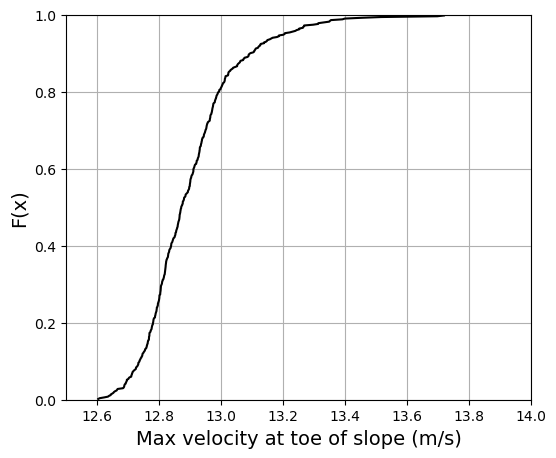

In [274]:
# Distribution of max velocities at the toe of the slope
def ecdf(var):
    x = np.sort(var)
    n = x.size
    y = np.arange(1, n+1) / (n+1)
    return [y, x]

max_max_velocities = [max_velocities[i].max() for i in range(simulations)]

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(ecdf(max_max_velocities)[1], ecdf(max_max_velocities)[0], color='k')
ax.set_ylabel('F(x)', fontsize=14)
ax.set_xlabel('Max velocity at toe of slope (m/s)', fontsize=14)
ax.grid()
ax.set_xlim(12.5, 14)
ax.set_ylim(0,1)

Cumulative erosion given maximum velocities

In [133]:
# coordinates_to_evaluate = np.linspace(0, slope_length, 100) #from previous

# compute turbulence parameters for each event and coordinate
omega_all = []
for k in range(simulations):
    r_0 = np.empty([len(samples), len(coordinates_to_evaluate)])
    for i in range(len(samples)):
        for j in range(len(coordinates_to_evaluate)):
            r_0[i,j] = 1.5 + 5*(np.sqrt(9.81*samples[k][i,1]*samples[k][i,2]*np.sin(angle_slope)/max_velocities[k][i,j]**3))
    omega_all.append(r_0)

# define parameters
critical_velocity = 5  # m/s
inverse_cover_strength = 10**(-6)  # s/m

# initialize erosion depth array
erosion = []

# compute erosion depth
for k in range(simulations):
    erosion_depth = np.zeros(len(coordinates_to_evaluate))
    for j in range(len(coordinates_to_evaluate)):
        for i in range(len(samples)):
            if omega_all[k][i,j]**2*max_velocities[k][i,j]**2 > critical_velocity**2:
                erosion_depth[j] = erosion_depth[j] + (omega_all[k][i,j]**2*max_velocities[k][i,j]**2-critical_velocity**2)*inverse_cover_strength*samples[k][i, 3]
    erosion.append(erosion_depth)

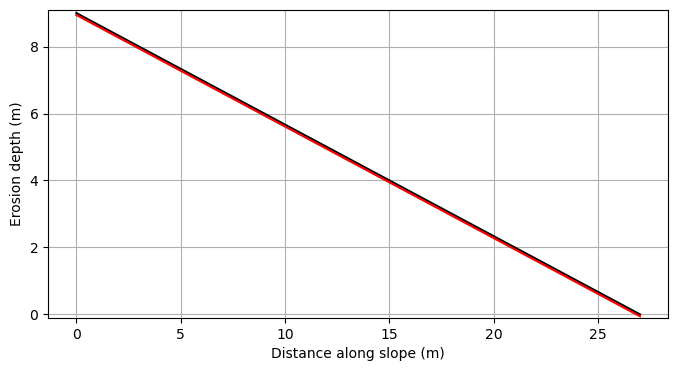

In [144]:
# Plot erosion depth
slope_heights = np.linspace(9, 0, 100)
projected_x_coord = coordinates_to_evaluate*np.cos(angle_slope)

fig, axes = plt.subplots(1,1, figsize=(8,4))
axes.plot(projected_x_coord, slope_heights, color='black', label ='Slope profile')
axes.plot(projected_x_coord, slope_heights - erosion_depth[5], color='red', label = 'Eroded profile')
axes.set_xlabel('Distance along slope (m)')
axes.set_ylabel('Erosion depth (m)')
axes.set_ylim(-0.1, 9.1)
axes.grid()

Text(0, 0.5, 'F(x)')

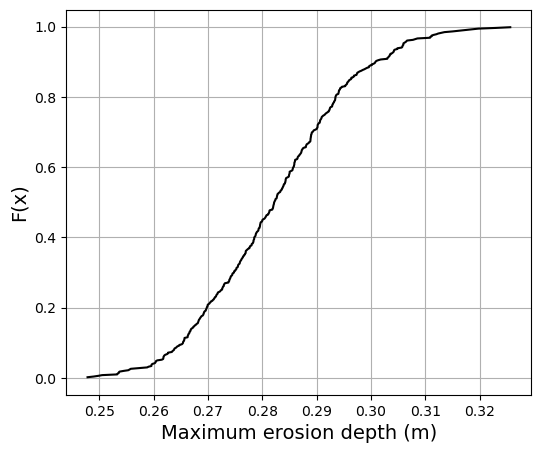

In [148]:
# Distribution of max erosion depth

def ecdf(var):
    x = np.sort(var)
    n = x.size
    y = np.arange(1, n+1) / (n+1)
    return [y, x]

max_erosion_depths = [max(erosion[i]) for i in range(simulations)]

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(ecdf(max_erosion_depths)[1], ecdf(max_erosion_depths)[0], label='Empirical CDF', color='k')
ax.grid()
ax.set_xlabel('Maximum erosion depth (m)', fontsize=14)
ax.set_ylabel('F(x)', fontsize=14)

### Inverse modelling: no molehills

Setting up the storms and velocities along the slope (same as previous section)

In [262]:
def steepness(Hs, Tm0):
    return Hs/((9.81*Tm0**2)/2/np.pi)

def iribarren(Hs, Tm0, angle_slope):
    return np.tan(angle_slope)/np.sqrt(steepness(Hs, Tm0))

def params_distr_vols(q, Hs, Tm0, Pov):
    Tm = 1.1*Tm0
    b = 0.73 + 55*(q/(9.81*Hs*Tm0))**(0.8)
    a = (1/special.gamma(1 + 1/b))*(q*Tm/Pov)
    return a, b

def pov(Rc, Ru):
    return np.exp(-((np.sqrt(-np.log(0.02)))*Rc/Ru)**2)

def Ru(Hs, Tm0, angle_slope):
    ru = 1.65*Hs*1*1*1*iribarren(Hs, Tm0, angle_slope)
    max_value = Hs*1*1*(4-1.5/iribarren(Hs, Tm0, angle_slope))
    return min(ru, max_value)

def mean_discharge(Hs, Tm0, Rc, angle_slope):
    estimation = 0.023*np.sqrt(9.81*Hs**3)*1*iribarren(Hs, Tm0, angle_slope)*np.exp(-(2.7*Rc/(Hs*iribarren(Hs, Tm0, angle_slope)))**1.3)
    max_value = 0.09*np.sqrt(9.81*Hs**3)*np.exp(-(1.5*Rc/Hs)**1.3)
    return min(estimation, max_value)

def weibull_cdf(V, a, b):
    return 1 - np.exp(-(V/a)**b)

def weibull_icdf(P, a, b):
    return a*(-np.log(1-P))**(1/b)

def individual_events(Hs, Tm0, Rc, angle_slope, Pov, n_samples, n_seed):
    q_mean = mean_discharge(Hs, Tm0, Rc, angle_slope)
    a, b = params_distr_vols(q_mean, Hs, Tm0, Pov)
    unif_samples = stats.uniform.rvs(0, 1, size = n_samples, random_state=n_seed)
    V_samples = weibull_icdf(unif_samples, a, b)
    vel_samples = 4.5*V_samples**0.3
    h_samples = 0.133*V_samples**0.5
    T_samples = 3.9*V_samples**0.46
    samples = np.vstack((V_samples, vel_samples, h_samples, T_samples)).T
    return samples

def max_u_horizontal(x_coord, friction, inst_Q, u_0):
    denom = friction*x_coord/(2*inst_Q) + 1/u_0
    u_horizontal = np.where(np.isfinite(denom) & (denom != 0),
                            1/denom,
                            np.nan)
    return u_horizontal

def max_u_slope(x_coord, u_0, friction, inst_Q, angle_slope):\
    # note tht x_coord is defined along the slope
    alpha = (9.81*np.sin(angle_slope))**(1/3)
    beta = np.sqrt(friction/2/inst_Q)
    mu = u_0 - alpha/beta
    u_slope = alpha/beta + mu*np.exp(-3*(beta**2)*alpha*x_coord/np.cos(angle_slope))
    return u_slope

# Case study data
total_height = 9
crest_legth = 4
slope = 3
angle_slope = math.atan(1/3)
# print(angle_slope*180/np.pi)
slope_length = 9/math.sin(angle_slope)
# print(slope_length)

# Input variables
Hs = 2
Tm0 = 7
water_level = 5
Rc = total_height - water_level
t_storm = 6 #hours of storm

# define parameters
friction = 0.01

# number of iterations
simulations = 500

# print(iribarren(Hs, Tm0, angle_slope))

# Number of overtopping events
n_events = np.round((t_storm*3600/(1.1*Tm0))*pov(Rc, Ru(Hs, Tm0, angle_slope)))


# Generate overtopping events for each possible storm
n_samples = int(n_events)
seeds = np.arange(1, simulations+1)
samples = [individual_events(Hs, Tm0, Rc, angle_slope, pov(Rc, Ru(Hs, Tm0, angle_slope)), 
                            n_samples, seeds[i]) for i in range(len(seeds))]

# max velocity at the end of the crest for all the samples
u_end_crest= [max_u_horizontal(4, friction, samples[i][:,1]*samples[i][:,2], samples[i][:,1]) for i in range(len(samples))]

# max velocity at the slope for all the samples
coordinates_to_evaluate = np.linspace(0, slope_length, 100)
friction = np.array([friction]*len(coordinates_to_evaluate))
max_velocities = []

for i in range(simulations):
    max_velocities_2d = np.zeros((len(samples), len(coordinates_to_evaluate)))
    for j in range(len(samples)):
        max_velocities_2d[j]=max_u_slope(coordinates_to_evaluate, u_end_crest[i][j], friction, 
                                 samples[i][j,1]*samples[i][j,2], angle_slope)
    max_velocities.append(max_velocities_2d)

# compute turbulence parameters for each event and coordinate
omega_all = []
for k in range(simulations):
    r_0 = np.empty([len(samples), len(coordinates_to_evaluate)])
    for i in range(len(samples)):
        for j in range(len(coordinates_to_evaluate)):
            r_0[i,j] = 1.5 + 5*(np.sqrt(9.81*samples[k][i,1]*samples[k][i,2]*np.sin(angle_slope)/max_velocities[k][i,j]**3))
    omega_all.append(r_0)

Visualize distribution of critical velocities by DM without molehills

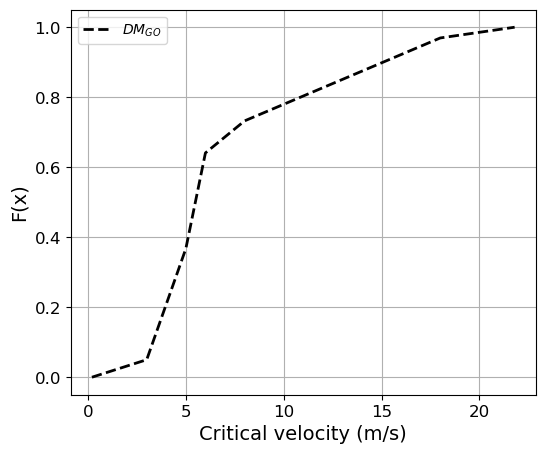

In [263]:
item = 'item15'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr]

# Plot experts' cdfs
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# for i, assessment in enumerate(itemassessment):
#     ax.plot(np.r_[np.exp(lower), assessment, np.exp(upper)], np.r_[0.0, project.assessments.quantiles, 1.0], color = expert_colors[i],
#             label='{}'.format(project.experts.ids[i]))
    
# Plot DM's cdf
ax.plot(*project.assessments.full_cdf['DMgl'][itemnr].T, label='${DM_{GO}}$', ms=4, color='k', ls='--', lw=2)
# ax.plot(*project.assessments.full_cdf['DMeq'][itemnr].T, label='${DM_{EW}}$', ms=4, color='k', ls=':', lw=2)

ax.legend()

ax.set_xlabel('Critical velocity (m/s)', fontsize=14)
ax.set_ylabel('F(x)', fontsize=14)
ax.grid()
# ax.set_ylim(0,1)
# ax.set_xlim(0,7)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

In [264]:
def eval_cdf(obs, x):
    interp_ecdf = interp1d(obs[:,1], obs[:,0], kind='linear')
    return interp_ecdf(x)

# samples of the critical_velocity m/s
unif_unity_uc = stats.uniform.rvs(0, 1, size = simulations, random_state=0)
unif_samples_uc = eval_cdf(project.assessments.full_cdf['DMgl'][itemnr], unif_unity_uc) 

inverse_cover_strength = 1  # s/m (so far since it is out of the summatory)

# initialize erosion depth array
erosion = []

# compute erosion depth
for k in range(simulations):
    erosion_depth = np.zeros(len(coordinates_to_evaluate))
    for j in range(len(coordinates_to_evaluate)):
        for i in range(len(samples)):
            if omega_all[k][i,j]**2*max_velocities[k][i,j]**2 > unif_samples_uc[k]**2:
                erosion_depth[j] = erosion_depth[j] + (omega_all[k][i,j]**2*max_velocities[k][i,j]**2-unif_samples_uc[k]**2)*inverse_cover_strength*samples[k][i, 3]
    erosion.append(erosion_depth)

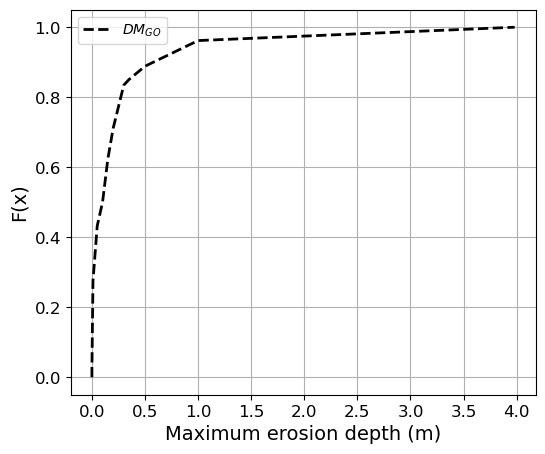

In [265]:
# Extract distribution of elicited erosions
item = 'item12'
itemnr = project.items.ids.index(item)

# # Get experts assessments for the item
# itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# # Get bounds for the item
# bounds = project.assessments.get_bounds(overshoot=0.1)
# lower, upper = bounds[0][itemnr], bounds[1][itemnr]

# Plot experts' cdfs
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# for i, assessment in enumerate(itemassessment):
#     ax.plot(np.r_[np.exp(lower), assessment, np.exp(upper)], np.r_[0.0, project.assessments.quantiles, 1.0], color = expert_colors[i],
#             label='{}'.format(project.experts.ids[i]))
    
# Plot DM's cdf
ax.plot(*project.assessments.full_cdf['DMgl'][itemnr].T, label='${DM_{GO}}$', ms=4, color='k', ls='--', lw=2)
# ax.plot(*project.assessments.full_cdf['DMeq'][itemnr].T, label='${DM_{EW}}$', ms=4, color='k', ls=':', lw=2)

ax.legend()

ax.set_xlabel('Maximum erosion depth (m)', fontsize=14)
ax.set_ylabel('F(x)', fontsize=14)
ax.grid()
# ax.set_ylim(0,1)
# ax.set_xlim(0,7)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)


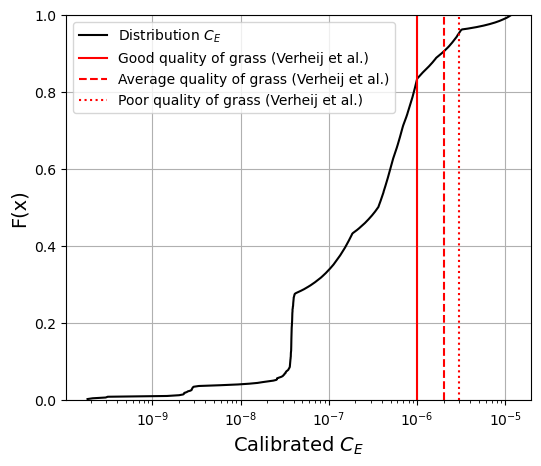

In [268]:
# Define and compare both CDFs
def ecdf(var):
    x = np.sort(var)
    n = x.size
    y = np.arange(1, n+1) / (n+1)
    return [y, x]

def eval_cdf_(obs, x):
    interp_ecdf = interp1d(obs[1], obs[0], kind='linear')
    return interp_ecdf(x)

max_erosion_to_cal = [max(erosion[i]) for i in range(simulations)]
ecdf_to_cal, x_to_cal = ecdf(max_erosion_to_cal)

# Evaluate the elicited distribution in the same non exceedance probabilities
x_to_cal_elicited = eval_cdf(project.assessments.full_cdf['DMgl'][project.items.ids.index('item12')], ecdf_to_cal)

# Divide one by the other to get the CE
ce_values_no = x_to_cal_elicited / x_to_cal

# Plot CDF CE
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(ecdf(ce_values_no)[1], ecdf(ce_values_no)[0], color='k', label = 'Distribution ${C_E}$')
ax.plot([10**(-6), 10**(-6)], [0, 1], 'r', label='Good quality of grass (Verheij et al.)')
ax.plot([2*10**(-6), 2*10**(-6)], [0, 1], '--r', label='Average quality of grass (Verheij et al.)')
ax.plot([3*10**(-6), 3*10**(-6)], [0, 1], ':r', label='Poor quality of grass (Verheij et al.)')
ax.set_ylim(0,1)
ax.set_xscale('log')
ax.grid()
ax.set_xlabel('Calibrated ${C_E}$', fontsize=14)
ax.set_ylabel('F(x)', fontsize=14)
ax.legend()

The higher the CE value, the worse quality of the grass and more erosion. Reported values by Varheij et al. of $C_E$ are on the high side of the distribution and, thus, in the conservative side (more erosion).

In [269]:
print(eval_cdf_(ecdf(ce_values_no), 10**(-6)))
print(eval_cdf_(ecdf(ce_values_no), 2*10**(-6)))
print(eval_cdf_(ecdf(ce_values_no), 3*10**(-6)))

0.8330045571755941
0.9046000201364998
0.9530578296813091


### Inverse modelling: with molehills

Setting up the storms and velocities along the slope (same as previous section)

In [ ]:
def steepness(Hs, Tm0):
    return Hs/((9.81*Tm0**2)/2/np.pi)

def iribarren(Hs, Tm0, angle_slope):
    return np.tan(angle_slope)/np.sqrt(steepness(Hs, Tm0))

def params_distr_vols(q, Hs, Tm0, Pov):
    Tm = 1.1*Tm0
    b = 0.73 + 55*(q/(9.81*Hs*Tm0))**(0.8)
    a = (1/special.gamma(1 + 1/b))*(q*Tm/Pov)
    return a, b

def pov(Rc, Ru):
    return np.exp(-((np.sqrt(-np.log(0.02)))*Rc/Ru)**2)

def Ru(Hs, Tm0, angle_slope):
    ru = 1.65*Hs*1*1*1*iribarren(Hs, Tm0, angle_slope)
    max_value = Hs*1*1*(4-1.5/iribarren(Hs, Tm0, angle_slope))
    return min(ru, max_value)

def mean_discharge(Hs, Tm0, Rc, angle_slope):
    estimation = 0.023*np.sqrt(9.81*Hs**3)*1*iribarren(Hs, Tm0, angle_slope)*np.exp(-(2.7*Rc/(Hs*iribarren(Hs, Tm0, angle_slope)))**1.3)
    max_value = 0.09*np.sqrt(9.81*Hs**3)*np.exp(-(1.5*Rc/Hs)**1.3)
    return min(estimation, max_value)

def weibull_cdf(V, a, b):
    return 1 - np.exp(-(V/a)**b)

def weibull_icdf(P, a, b):
    return a*(-np.log(1-P))**(1/b)

def individual_events(Hs, Tm0, Rc, angle_slope, Pov, n_samples, n_seed):
    q_mean = mean_discharge(Hs, Tm0, Rc, angle_slope)
    a, b = params_distr_vols(q_mean, Hs, Tm0, Pov)
    unif_samples = stats.uniform.rvs(0, 1, size = n_samples, random_state=n_seed)
    V_samples = weibull_icdf(unif_samples, a, b)
    vel_samples = 4.5*V_samples**0.3
    h_samples = 0.133*V_samples**0.5
    T_samples = 3.9*V_samples**0.46
    samples = np.vstack((V_samples, vel_samples, h_samples, T_samples)).T
    return samples

def max_u_horizontal(x_coord, friction, inst_Q, u_0):
    denom = friction*x_coord/(2*inst_Q) + 1/u_0
    u_horizontal = np.where(np.isfinite(denom) & (denom != 0),
                            1/denom,
                            np.nan)
    return u_horizontal

def max_u_slope(x_coord, u_0, friction, inst_Q, angle_slope):\
    # note tht x_coord is defined along the slope
    alpha = (9.81*np.sin(angle_slope))**(1/3)
    beta = np.sqrt(friction/2/inst_Q)
    mu = u_0 - alpha/beta
    u_slope = alpha/beta + mu*np.exp(-3*(beta**2)*alpha*x_coord/np.cos(angle_slope))
    return u_slope

# Case study data
total_height = 9
crest_legth = 4
slope = 3
angle_slope = math.atan(1/3)
# print(angle_slope*180/np.pi)
slope_length = 9/math.sin(angle_slope)
# print(slope_length)

# Input variables
Hs = 2
Tm0 = 7
water_level = 5
Rc = total_height - water_level
t_storm = 6 #hours of storm

# define parameters
friction = 0.01

# number of iterations
simulations = 500

# print(iribarren(Hs, Tm0, angle_slope))

# Number of overtopping events
n_events = np.round((t_storm*3600/(1.1*Tm0))*pov(Rc, Ru(Hs, Tm0, angle_slope)))


# Generate overtopping events for each possible storm
n_samples = int(n_events)
seeds = np.arange(1, simulations+1)
samples = [individual_events(Hs, Tm0, Rc, angle_slope, pov(Rc, Ru(Hs, Tm0, angle_slope)), 
                            n_samples, seeds[i]) for i in range(len(seeds))]

# max velocity at the end of the crest for all the samples
u_end_crest= [max_u_horizontal(4, friction, samples[i][:,1]*samples[i][:,2], samples[i][:,1]) for i in range(len(samples))]

# max velocity at the slope for all the samples
coordinates_to_evaluate = np.linspace(0, slope_length, 100)
friction = np.array([friction]*len(coordinates_to_evaluate))
max_velocities = []

for i in range(simulations):
    max_velocities_2d = np.zeros((len(samples), len(coordinates_to_evaluate)))
    for j in range(len(samples)):
        max_velocities_2d[j]=max_u_slope(coordinates_to_evaluate, u_end_crest[i][j], friction, 
                                 samples[i][j,1]*samples[i][j,2], angle_slope)
    max_velocities.append(max_velocities_2d)

# compute turbulence parameters for each event and coordinate
omega_all = []
for k in range(simulations):
    r_0 = np.empty([len(samples), len(coordinates_to_evaluate)])
    for i in range(len(samples)):
        for j in range(len(coordinates_to_evaluate)):
            r_0[i,j] = 1.5 + 5*(np.sqrt(9.81*samples[k][i,1]*samples[k][i,2]*np.sin(angle_slope)/max_velocities[k][i,j]**3))
    omega_all.append(r_0)

Visualize distribution of critical velocities by DM without molehills

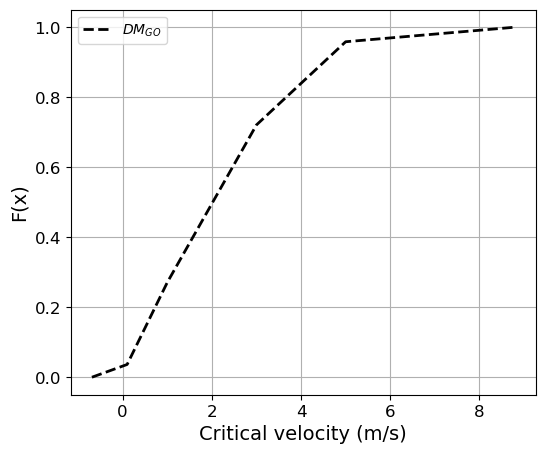

In [256]:
item = 'item16'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr]

# Plot experts' cdfs
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# for i, assessment in enumerate(itemassessment):
#     ax.plot(np.r_[np.exp(lower), assessment, np.exp(upper)], np.r_[0.0, project.assessments.quantiles, 1.0], color = expert_colors[i],
#             label='{}'.format(project.experts.ids[i]))
    
# Plot DM's cdf
ax.plot(*project.assessments.full_cdf['DMgl'][itemnr].T, label='${DM_{GO}}$', ms=4, color='k', ls='--', lw=2)
# ax.plot(*project.assessments.full_cdf['DMeq'][itemnr].T, label='${DM_{EW}}$', ms=4, color='k', ls=':', lw=2)

ax.legend()

ax.set_xlabel('Critical velocity (m/s)', fontsize=14)
ax.set_ylabel('F(x)', fontsize=14)
ax.grid()
# ax.set_ylim(0,1)
# ax.set_xlim(0,7)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

In [257]:
def eval_cdf(obs, x):
    interp_ecdf = interp1d(obs[:,1], obs[:,0], kind='linear')
    return interp_ecdf(x)

# samples of the critical_velocity m/s
unif_unity_uc = stats.uniform.rvs(0, 1, size = simulations, random_state=0)
unif_samples_uc = eval_cdf(project.assessments.full_cdf['DMgl'][itemnr], unif_unity_uc) 

inverse_cover_strength = 1  # s/m (so far since it is out of the summatory)

# initialize erosion depth array
erosion = []

# compute erosion depth
for k in range(simulations):
    erosion_depth = np.zeros(len(coordinates_to_evaluate))
    for j in range(len(coordinates_to_evaluate)):
        for i in range(len(samples)):
            if omega_all[k][i,j]**2*max_velocities[k][i,j]**2 > unif_samples_uc[k]**2:
                erosion_depth[j] = erosion_depth[j] + (omega_all[k][i,j]**2*max_velocities[k][i,j]**2-unif_samples_uc[k]**2)*inverse_cover_strength*samples[k][i, 3]
    erosion.append(erosion_depth)

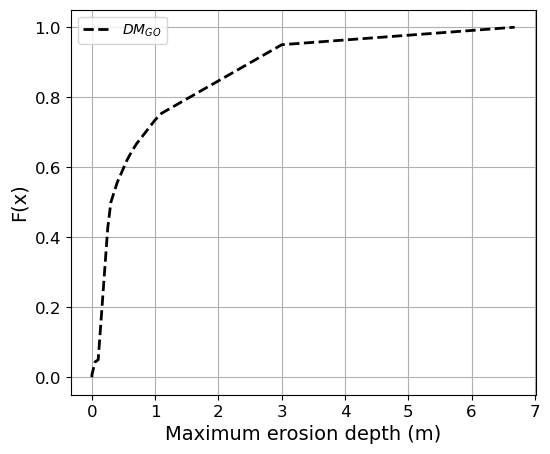

In [258]:
# Extract distribution of elicited erosions
item = 'item13'
itemnr = project.items.ids.index(item)

# # Get experts assessments for the item
# itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# # Get bounds for the item
# bounds = project.assessments.get_bounds(overshoot=0.1)
# lower, upper = bounds[0][itemnr], bounds[1][itemnr]

# Plot experts' cdfs
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# for i, assessment in enumerate(itemassessment):
#     ax.plot(np.r_[np.exp(lower), assessment, np.exp(upper)], np.r_[0.0, project.assessments.quantiles, 1.0], color = expert_colors[i],
#             label='{}'.format(project.experts.ids[i]))
    
# Plot DM's cdf
ax.plot(*project.assessments.full_cdf['DMgl'][itemnr].T, label='${DM_{GO}}$', ms=4, color='k', ls='--', lw=2)
# ax.plot(*project.assessments.full_cdf['DMeq'][itemnr].T, label='${DM_{EW}}$', ms=4, color='k', ls=':', lw=2)

ax.legend()

ax.set_xlabel('Maximum erosion depth (m)', fontsize=14)
ax.set_ylabel('F(x)', fontsize=14)
ax.grid()
# ax.set_ylim(0,1)
# ax.set_xlim(0,7)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)


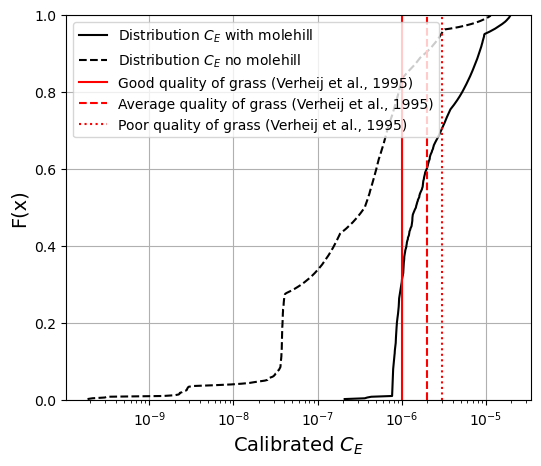

In [271]:
# Define and compare both CDFs
def ecdf(var):
    x = np.sort(var)
    n = x.size
    y = np.arange(1, n+1) / (n+1)
    return [y, x]

def eval_cdf_(obs, x):
    interp_ecdf = interp1d(obs[1], obs[0], kind='linear')
    return interp_ecdf(x)

max_erosion_to_cal = [max(erosion[i]) for i in range(simulations)]
ecdf_to_cal, x_to_cal = ecdf(max_erosion_to_cal)

# Evaluate the elicited distribution in the same non exceedance probabilities
x_to_cal_elicited = eval_cdf(project.assessments.full_cdf['DMgl'][project.items.ids.index('item13')], ecdf_to_cal)

# Divide one by the other to get the CE
ce_values = x_to_cal_elicited / x_to_cal

# Plot CDF CE
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(ecdf(ce_values)[1], ecdf(ce_values)[0], color='k', label = 'Distribution ${C_E}$ with molehill')
ax.plot(ecdf(ce_values_no)[1], ecdf(ce_values_no)[0], '--k', label = 'Distribution ${C_E}$ no molehill')
ax.plot([10**(-6), 10**(-6)], [0, 1], 'r', label='Good quality of grass (Verheij et al., 1995)')
ax.plot([2*10**(-6), 2*10**(-6)], [0, 1], '--r', label='Average quality of grass (Verheij et al., 1995)')
ax.plot([3*10**(-6), 3*10**(-6)], [0, 1], ':r', label='Poor quality of grass (Verheij et al., 1995)')
ax.set_ylim(0,1)
ax.set_xscale('log')
ax.grid()
ax.set_xlabel('Calibrated ${C_E}$', fontsize=14)
ax.set_ylabel('F(x)', fontsize=14)
ax.legend()

The higher the CE value, the worse quality of the grass and more erosion. Reported values by Verheij et al. of $C_E$ are on the high side of the distribution and, thus, in the conservative side (more erosion).

In [260]:
print(eval_cdf_(ecdf(ce_values), 10**(-6)))
print(eval_cdf_(ecdf(ce_values), 2*10**(-6)))
print(eval_cdf_(ecdf(ce_values), 3*10**(-6)))

0.5011161989325676
0.6400864937562162
0.7206903947768669


### Last cell